<a href="https://colab.research.google.com/github/bhattacharjee/msc-ai-project/blob/main/iteration_3.0.ipynb/Autoencoder_iteration_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging, sys, random, glob
from google.colab import drive
from functools import lru_cache
import sklearn
from sklearn.model_selection import train_test_split

from tensorflow import keras as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import IPython


drive.mount("/content/drive")

def set_random_seed():
    np.random.seed(1)
    random.seed(1)
    tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

!cp -r /content/drive/MyDrive/MSCPROJDATA .

Mounted at /content/drive


In [3]:
def get_columns(thisdf):
    baseline_columns = [c for c in thisdf.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
    baseline_columns = [c for c in baseline_columns if "filesize" not in c]
    baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

    advanced_columns = [c for c in thisdf.columns if "advanced" in c]
    advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
    advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
    advanced_columns = [c for c in advanced_columns if "start" not in c]
    advanced_columns_only = list(set(advanced_columns))
    advanced_columns = list(set(advanced_columns + baseline_columns))

    fourier_columns = [c for c in thisdf.columns if "fourier" in c and "value" not in c]
    fourier_columns = [c for c in fourier_columns if "1byte" in c]
    fourier_columns = [c for c in fourier_columns if "begin" not in c and "end" not in c]
    fourier_columns = [c for c in fourier_columns if "head" not in c and "tail" not in c]
    fourier_columns = [c for c in fourier_columns if "start" not in c]
    fourier_columns_only = list(set(fourier_columns))
    fourier_columns = list(set(advanced_columns + fourier_columns))
    
    baseline_and_advanced = list(set(baseline_columns + advanced_columns_only))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns_only))
    advanced_and_fourier = list(set(advanced_columns_only + fourier_columns_only))
    
    return {\
        "baseline": baseline_columns,\
        "advanced-only": advanced_columns_only,\
        "fourier-only": fourier_columns_only,\
        "baseline-and-fourier": baseline_and_fourier,\
        "advanced-and-fourier": advanced_and_fourier,\
        "advanced": advanced_columns,\
        "fourier": fourier_columns,\
    }

@lru_cache(maxsize=5)
def load_datasets_once():
    """Load all datasets only once
    
    We want to load the datasets only once. Once loaded
    serve from cache
    """
    datasets = dict()
    for file in glob.glob("MSCPROJDATA/**.parquet.gz", recursive=True):
        print(f"Loading {file}")
        df = pd.read_parquet(file)
        df = df.sample(frac=1).reset_index(drop=True)
        df["is_encrypted"] = 1 if "encr" in file.lower() else 0
        datasets[file] = df
    return datasets

In [90]:
all_datasets = load_datasets_once()
full_dataset = pd.concat(all_datasets.values())
encrypted_df = full_dataset[full_dataset["is_encrypted"] == 1]
non_encrypted_df = full_dataset[full_dataset["is_encrypted"] == 0]

# shuffle
encrypted_df = encrypted_df.sample(frac=1).reset_index(drop=True)
non_encrypted_df = non_encrypted_df.sample(frac=1).reset_index(drop=True)

columns = []
for c in get_columns(full_dataset).values():
    columns += c
columns = list(set(columns))

work_encrypted_df_X = encrypted_df[columns]
work_encrypted_df_y = encrypted_df["is_encrypted"]
work_non_encrypted_df_X = non_encrypted_df[columns]
work_non_encrypted_df_y = non_encrypted_df["is_encrypted"]

def normalize_df(X, Y):
    mindf = X.min()
    maxdf = X.max()
    X = (X - mindf) / (maxdf - mindf)
    Y = (Y - mindf) / (maxdf - mindf)
    return X, Y

work_encrypted_df_X, work_non_encrypted_df_X = \
    normalize_df(
        work_encrypted_df_X,
        work_non_encrypted_df_X
    )

In [91]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(\
        work_encrypted_df_X,
        work_encrypted_df_y,
        test_size=0.33,
        random_state=42)

X_train.shape

(216686, 63)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 64)                4096      
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dense_37 (Dense)            (None, 16)                528       
                                                                 
 dense_38 (Dense)            (None, 32)                544       
                                                                 
 dense_39 (Dense)            (None, 63)                2079      
                                                                 
Total params: 9,327
Trainable params: 9,327
Non-trainable params: 0
_________________________________________________________________
None


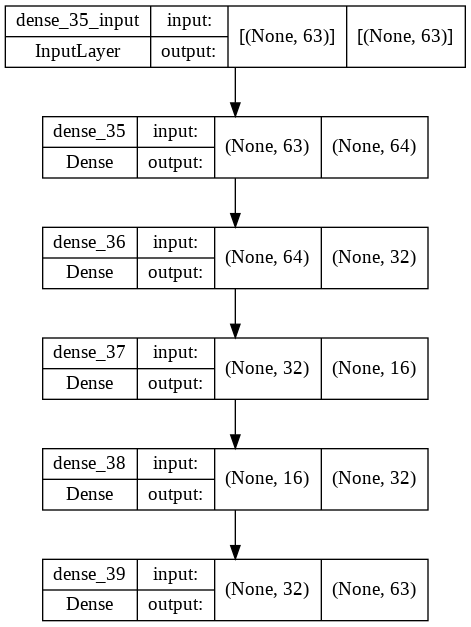

(129364, 63) (32342, 63)
Epoch 1/25
8086/8086 [==============================] - 34s 4ms/step - loss: 0.0015 - mae: 0.0104 - mse: 0.0015 - val_loss: 1.4273e-04 - val_mae: 0.0046 - val_mse: 1.4273e-04
Epoch 2/25
8086/8086 [==============================] - 32s 4ms/step - loss: 9.0357e-05 - mae: 0.0041 - mse: 9.0357e-05 - val_loss: 7.4145e-05 - val_mae: 0.0037 - val_mse: 7.4145e-05
Epoch 3/25
8086/8086 [==============================] - 31s 4ms/step - loss: 5.1664e-05 - mae: 0.0031 - mse: 5.1664e-05 - val_loss: 5.4216e-05 - val_mae: 0.0029 - val_mse: 5.4216e-05
Epoch 4/25
6313/8086 [======================>.......] - ETA: 5s - loss: 4.4001e-05 - mae: 0.0029 - mse: 4.4001e-05

In [ ]:


class Autoencoder:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
                #layers.Dropout(0.25),
                layers.Dense(16, activation='relu'),
                #layers.Dropout(0.25),
                layers.Dense(32, activation='relu'),
                #layers.Dropout(0.25),
                layers.Dense(63, activation='sigmoid'),
            ]
        )
        return model



def print_and_plot(model):
    print(model.summary())
    plot = tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        expand_nested=True)
    IPython.display.display(plot)


from sklearn.model_selection import train_test_split
def create_and_train_autoencoder(X, y):
    X_train, X_eval, y_train, y_eval= \
        train_test_split(X, y, test_size=0.2, random_state=42)

    nn = Autoencoder.build()
    nn.compile(optimizer='adam', loss='mse', metrics=["mae", "mse"])

    nn.build((None, X.shape[1]))
    print_and_plot(nn)

    print(X_train.shape, X_eval.shape)
    history = nn.fit(X_train, X_train,
                epochs=25,
                validation_data=(X_eval, X_eval),
                batch_size=16)
    return nn, history


# Encrypted section, use half for training, we will use the remaining
# half for testing

eTrain_X, eTest_X, eTrain_y, eTest_y = \
    train_test_split(work_encrypted_df_X, work_encrypted_df_y, test_size=0.5, random_state=42)
nn, history = create_and_train_autoencoder(eTrain_X, eTrain_y)

_, neTest_X, _, neTest_y = \
    train_test_split(work_non_encrypted_df_X, work_non_encrypted_df_y, test_size=0.5, random_state=42)

final_test_X = pd.concat([eTest_X, neTest_X])
final_test_y = pd.concat([eTest_y, neTest_y])

In [ ]:
plt.rcParams["figure.figsize"] = (6, 3)

for metric in ["loss", "mse", "mae"]:
    keys = []
    for k, v in history.history.items():
        if metric in k.lower():
            keys.append(k)
            plt.plot(v, label=k)
        plt.legend(keys)
    plt.show()

In [ ]:
reconstructed_test_X = nn.predict(final_test_X)

In [32]:
print(reconstructed_test_X.shape, final_test_X.shape)

(323412, 63) (323412, 63)


In [ ]:
def get_mse_mae(X, X1):
    saveX, saveX1 = X, X1
    if not isinstance(X, np.ndarray):
        X = X.to_numpy()
    if not isinstance(X1, np.ndarray):
        X1 = X1.to_numpy()
    square_error = np.square(X - X1)
    mse = np.mean(square_error, axis=1)
    abs_error = np.square(X - X1)
    mae = np.mean(abs_error, axis=1)
    return mse, mae



mse, mae = get_mse_mae(final_test_X, reconstructed_test_X)


df_result = pd.DataFrame(\
    {\
        "is_encrypted": final_test_y,\
        "mse": mse,\
        "mae": mae,\
    }\
)

df_result2 = df_result[df_result["mae"] < 0.1]
sns.stripplot(data=df_result2, x="is_encrypted", y="mae").set(title="Mean Absolute Error")
plt.show()
sns.stripplot(data=df_result2, x="is_encrypted", y="mse").set(title="Mean Square Error")
plt.show()


In [ ]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

df = df_result[df_result["mae"] < 0.1]
y_pred = df["mse"].to_numpy()
y_true = df["is_encrypted"].to_numpy()

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true=y_true, y_score=y_pred)
auc_score = auc(fpr, tpr)
print(auc_score)

In [ ]:
plt.plot(fpr, tpr)